# PIP

In [16]:
# pip install gymnasium ipywidgets

# LOCKANDKEY

## 1 IMPORTS

In [121]:
# CELL 1: Imports & helpers
# Paste in first cell

import os
import time
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# Pygame used for menu + visualization
import pygame

# Small safe initializer used before creating fonts/displays
def pygame_safe_init():
    if not pygame.get_init():
        pygame.init()
    if not pygame.font.get_init():
        pygame.font.init()

# small helper: moving average
def moving_avg(arr, window):
    if len(arr) < window:
        return np.array(arr)
    return np.convolve(arr, np.ones(window)/window, mode='valid')


## 2 RL AGENTS

In [122]:
# CELL 2: RL Agents (Q-Learning, Monte Carlo, Actor-Critic)
import numpy as np
from collections import defaultdict

# --- Utility to make states hashable ---
def hashable_state(s):
    """
    Convert dict, ndarray, or list observation into a hashable key.
    For our env the observation is an integer, so hashing is trivial.
    This helper keeps the agent code general.
    """
    if isinstance(s, dict):
        return tuple(sorted((k, hashable_state(v)) for k, v in s.items()))
    elif isinstance(s, np.ndarray):
        return tuple(map(float, s.flatten()))
    elif isinstance(s, (list, tuple)):
        return tuple(map(hashable_state, s))
    else:
        try:
            hash(s)
            return s
        except TypeError:
            return str(s)


# ----------------- Q-Learning Agent -----------------
class QLearningAgent:
    def __init__(self, n_states=None, n_actions=6, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))

    def select_action(self, state):
        state = hashable_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, state, action, reward, next_state, done):
        state = hashable_state(state)
        next_state = hashable_state(next_state)
        target = reward + self.gamma * np.max(self.Q[next_state]) * (1 - done)
        current = self.Q[state][action]
        self.Q[state][action] = current + self.alpha * (target - current)


# ----------------- Monte Carlo Agent -----------------
class MonteCarloAgent:
    def __init__(self, n_states=None, n_actions=6, gamma=0.9, epsilon=0.1, alpha=0.05):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha  # NEW: learning rate
        self.Q = defaultdict(lambda: np.zeros(self.n_actions))
        self.returns = defaultdict(list)

    def select_action(self, state):
        state = hashable_state(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return int(np.argmax(self.Q[state]))

    def update(self, episode):
        """Episode is a list of (state, action, reward)."""
        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            state = hashable_state(state)
            G = self.gamma * G + reward
            if (state, action) not in visited:
                old_value = self.Q[state][action]
                # Instead of averaging, apply incremental update
                self.Q[state][action] = old_value + self.alpha * (G - old_value)
                visited.add((state, action))



# ----------------- Actor-Critic Agent -----------------
class ActorCriticAgent:
    def __init__(self, n_states=None, n_actions=6, alpha=0.1, beta=0.01, gamma=0.9):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha  # critic lr
        self.beta = beta    # actor lr
        self.gamma = gamma

        self.V = defaultdict(float)
        self.pi = defaultdict(lambda: np.ones(self.n_actions) / self.n_actions)

    def select_action(self, state):
        state = hashable_state(state)
        probs = self.pi[state]
        return np.random.choice(self.n_actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        state = hashable_state(state)
        next_state = hashable_state(next_state)

        # TD error
        td_target = reward + self.gamma * self.V[next_state] * (1 - done)
        td_error = td_target - self.V[state]
        self.V[state] += self.alpha * td_error

        # Actor update
        probs = self.pi[state]
        one_hot = np.zeros_like(probs)
        one_hot[action] = 1.0
        self.pi[state] += self.beta * td_error * (one_hot - probs)

        # Normalize
        self.pi[state] = np.clip(self.pi[state], 1e-5, 1.0)
        self.pi[state] /= np.sum(self.pi[state])


## 3 PYGAME MENU

In [123]:
# ----------------- CELL 3: Stable UI with Accurate Sliders (2-decimal, Updated Beta + MC LR) -----------------
def draw_button(screen, rect, text, font, color=(180,220,255), border=2):
    pygame.draw.rect(screen, color, rect)
    pygame.draw.rect(screen, (0,0,0), rect, border)
    txt = font.render(text, True, (0,0,0))
    screen.blit(txt, (rect.x + (rect.width - txt.get_width())//2, rect.y + (rect.height - txt.get_height())//2))

def draw_slider(screen, x, y, w, val, min_val, max_val, label, font, knob_r=10):
    """
    Draws a slider and returns the knob rectangle.
    - Ensures knob is computed from a clamped value.
    - Displays value with 2 decimals.
    """
    range_span = max_val - min_val if (max_val - min_val) != 0 else 1e-6
    clamped_val = max(min_val, min(max_val, float(val)))
    frac = (clamped_val - min_val) / range_span
    knob_x = int(x + frac * w)

    # track
    track_rect = pygame.Rect(x, y, w, 6)
    pygame.draw.rect(screen, (220,220,220), track_rect)

    # knob
    pygame.draw.circle(screen, (80,80,200), (knob_x, y+3), knob_r)

    # label (2 decimals)
    txt = font.render(f"{label}: {clamped_val:.2f}", True, (0,0,0))
    screen.blit(txt, (x, y - 28))

    return pygame.Rect(knob_x - knob_r, y+3 - knob_r, knob_r*2, knob_r*2)

def draw_input_box(screen, rect, text, font, active):
    color = (200,255,200) if active else (255,255,255)
    pygame.draw.rect(screen, color, rect)
    pygame.draw.rect(screen, (0,0,0), rect, 2)
    txt_surface = font.render(str(text), True, (0,0,0))
    screen.blit(txt_surface, (rect.x+5, rect.y+5))

def menu_and_params(initial_params=None):
    pygame_safe_init()
    w,h = 980, 640
    screen = pygame.display.set_mode((w,h))
    pygame.display.set_caption('Locke N Key — Setup (Phase → Algo → Params)')
    font = pygame.font.SysFont('arial', 22)
    small = pygame.font.SysFont('arial', 16)

    algo_choices = ['Q-Learning', 'Monte Carlo', 'Actor-Critic']
    algo_idx = 0
    phase_idx = 1

    # --- Default parameters (MC_LR included) ---
    params = {
        'episodes': '100',
        'alpha': 0.10,
        'beta': 0.10,
        'gamma': 0.90,
        'epsilon': 0.20,
        'MC_LR': 0.05,
        'phase': phase_idx
    }
    if initial_params:
        params.update(initial_params)

    stage = 0
    dragging = None
    drag_offset = 0
    active_box = False
    input_rect = pygame.Rect(760, 250, 150, 36)
    clock = pygame.time.Clock()
    start_sim = False
    running = True
    knobs = {}

    def clamp(v, a, b): return max(a, min(b, v))

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit(); raise SystemExit()

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_RIGHT:
                    if stage == 0:
                        phase_idx = min(5, phase_idx + 1)
                    elif stage == 1:
                        algo_idx = (algo_idx + 1) % len(algo_choices)
                elif event.key == pygame.K_LEFT:
                    if stage == 0:
                        phase_idx = max(1, phase_idx - 1)
                    elif stage == 1:
                        algo_idx = (algo_idx - 1) % len(algo_choices)
                elif event.key == pygame.K_RETURN:
                    if stage < 2:
                        stage += 1
                    else:
                        start_sim = True
                elif event.key == pygame.K_BACKSPACE:
                    if active_box:
                        params['episodes'] = params['episodes'][:-1]
                    elif stage > 0:
                        stage -= 1
                elif active_box and event.unicode.isdigit():
                    params['episodes'] += event.unicode

            elif event.type == pygame.MOUSEBUTTONDOWN:
                mx,my = pygame.mouse.get_pos()
                if input_rect.collidepoint(mx,my):
                    active_box = True
                else:
                    active_box = False

                if event.button == 1:
                    for k, meta in knobs.items():
                        if meta['rect'].collidepoint(mx, my):
                            dragging = k
                            knob_center_x = meta['rect'].centerx
                            drag_offset = mx - knob_center_x
                            break

            elif event.type == pygame.MOUSEBUTTONUP:
                dragging = None
                drag_offset = 0

            elif event.type == pygame.MOUSEMOTION and dragging:
                mx,my = pygame.mouse.get_pos()
                meta = knobs.get(dragging)
                if meta is None:
                    dragging = None
                    continue

                x, w = meta['x'], meta['w']
                min_v, max_v = meta['min'], meta['max']
                stick_x = clamp(mx - drag_offset, x, x + w)
                rel = (stick_x - x) / float(w) if w != 0 else 0.0
                new_val = round(min_v + rel * (max_v - min_v), 2)
                new_val = clamp(new_val, min_v, max_v)
                params[meta['param_key']] = new_val

                knob_x = int(x + ((new_val - min_v) / (max_v - min_v if (max_v-min_v)!=0 else 1e-6)) * w)
                knob_r = meta.get('knob_r', 10)
                meta_rect = pygame.Rect(knob_x - knob_r, meta['y_center'] - knob_r, knob_r*2, knob_r*2)
                meta['rect'] = meta_rect
                knobs[dragging] = meta

        # --- Draw UI ---
        screen.fill((245,245,245))
        title = font.render('Locke N Key — Setup (Phase → Algo → Params)', True, (20,20,20))
        screen.blit(title, (40,20))

        stage_texts = ['Select Phase (ENTER next)', 'Select Algorithm (ENTER next)', 'Tune Params / Start (ENTER start)']
        screen.blit(small.render(stage_texts[stage], True, (60,60,60)), (40,60))

        # Phase box
        phase_box = pygame.Rect(50, 100, 300, 80)
        pygame.draw.rect(screen, (200,230,200) if stage==0 else (220,220,220), phase_box)
        pygame.draw.rect(screen, (0,0,0), phase_box, 2)
        ptxt = font.render(f"Phase: {phase_idx}", True, (0,0,0))
        screen.blit(ptxt, (phase_box.x + 20, phase_box.y + 20))
        descs = {
            1: "Fixed positions (no enemy)",
            2: "Random agent/key, fixed lock",
            3: "Random agent/key/lock",
            4: "Randomized tuning (like Phase 3)",
            5: "Adds moving enemy hazard"
        }
        screen.blit(small.render(descs[phase_idx], True, (40,40,40)), (phase_box.x + 20, phase_box.y + 48))

        # Algorithm selection
        algo_box = pygame.Rect(380, 100, 520, 80)
        pygame.draw.rect(screen, (200,230,255) if stage==1 else (240,240,240), algo_box)
        pygame.draw.rect(screen, (0,0,0), algo_box, 2)
        algo_txt = font.render(f"Algorithm: {algo_choices[algo_idx]}", True, (0,0,0))
        screen.blit(algo_txt, (algo_box.x + 20, algo_box.y + 20))

        # Sliders
        algo = algo_choices[algo_idx]
        knobs.clear()
        if stage == 2:
            y = 220
            track_x = 180
            track_w = 480

            if algo == 'Q-Learning':
                r = draw_slider(screen, track_x, y+20, track_w, params['alpha'], 0.001, 1.0, "Alpha (Learning Rate)", font)
                knobs['alpha'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.001, 'max':1.0, 'param_key':'alpha', 'y_center': (y+20)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+80, track_w, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)
                knobs['gamma'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.5, 'max':0.99, 'param_key':'gamma', 'y_center': (y+80)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+140, track_w, params['epsilon'], 0.0, 1.0, "Epsilon (Exploration)", font)
                knobs['epsilon'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.0, 'max':1.0, 'param_key':'epsilon', 'y_center': (y+140)+3, 'knob_r':10}

            elif algo == 'Monte Carlo':
                r = draw_slider(screen, track_x, y+20, track_w, params.get('MC_LR', 0.05), 0.001, 1.0, "MC Learning Rate", font)
                knobs['MC_LR'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.001, 'max':1.0, 'param_key':'MC_LR', 'y_center': (y+20)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+80, track_w, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)
                knobs['gamma'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.5, 'max':0.99, 'param_key':'gamma', 'y_center': (y+80)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+140, track_w, params['epsilon'], 0.0, 1.0, "Epsilon (Exploration)", font)
                knobs['epsilon'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.0, 'max':1.0, 'param_key':'epsilon', 'y_center': (y+140)+3, 'knob_r':10}

            elif algo == 'Actor-Critic':
                r = draw_slider(screen, track_x, y+20, track_w, params['alpha'], 0.001, 1.0, "Alpha (Critic LR)", font)
                knobs['alpha'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.001, 'max':1.0, 'param_key':'alpha', 'y_center': (y+20)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+80, track_w, params['beta'], 0.001, 1.0, "Beta (Actor LR)", font)
                knobs['beta'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.001, 'max':1.0, 'param_key':'beta', 'y_center': (y+80)+3, 'knob_r':10}

                r = draw_slider(screen, track_x, y+140, track_w, params['gamma'], 0.5, 0.99, "Gamma (Discount)", font)
                knobs['gamma'] = {'rect': r, 'x': track_x, 'w': track_w, 'min':0.5, 'max':0.99, 'param_key':'gamma', 'y_center': (y+140)+3, 'knob_r':10}

        # Episodes input
        draw_input_box(screen, input_rect, params['episodes'], font, active_box)
        screen.blit(small.render("Episodes:", True, (0,0,0)), (680, 260))

        # Hint text
        screen.blit(small.render('←/→ to change • ENTER = Next/Start • BACKSPACE = Back • Drag sliders to adjust', True, (60,60,60)), (40, 580))

        pygame.display.update()
        clock.tick(30)

        if start_sim:
            pygame.quit()
            params['episodes'] = int(params['episodes']) if str(params['episodes']).isdigit() else 500
            params['phase'] = phase_idx
            return algo_choices[algo_idx], params


## 4 ENVIRONMENT

In [ ]:
# ----------------- CELL 4: Simplified In-notebook Environment (with Image Placeholders + Speed Control + Distance Reward + Trailing Enemy) -----------------
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame
import os, sys, random
from collections import deque

# Safe init for pygame (avoids repeated initialization errors in Jupyter)
def pygame_safe_init():
    if not pygame.get_init():
        pygame.init()
        pygame.display.init()

class LockKeyEnv(gym.Env):
    """
    Lock & Key Puzzle Environment
    Now includes an enemy that follows the agent's trail (2–3 steps behind).
    Reward shaping includes:
      - Moving closer to the key (before pickup)
      - Moving closer to the door (after having key)
      - Staying farther from the enemy
      - Major rewards for key pickup & door unlock
    """

    metadata = {"render_modes": ["human"], "render_fps": 5}

    def __init__(self, render_mode="human", size=6, phase=1, seed=None):
        super().__init__()
        assert phase in (1,2,3,4,5), "Phase must be 1–5"
        self.size = size
        self.phase = phase
        self._rng = np.random.default_rng(seed)

        # Window and grid parameters
        self.window_size = 800
        self.grid_size = 500
        self.info_width = self.window_size - self.grid_size
        self.cell_size = self.grid_size // self.size

        # Spaces
        self.action_space = spaces.Discrete(6)
        self.observation_space = spaces.Discrete(self.size**6)

        # Default object states
        self._default_agent_pos = np.array([5, 0])
        self._default_key_pos = np.array([5, 3])
        self._default_lock_pos = np.array([0, 5])
        self.walls = {(0,2),(1,1),(1,4),(2,3),(3,0),(3,2),(4,4)}

        # Enemy
        self.enemy_pos = None
        self.enemy_active = (phase == 5)
        self.trail = deque(maxlen=4)  # store last few agent positions for enemy following

        # State variables
        self.agent_pos = None
        self.key_pos = None
        self.lock_pos = None
        self.has_key = False
        self.steps = 0
        self.last_reward = 0
        self.current_episode = 0

        # Track distances for shaping
        self.prev_enemy_dist = None
        self.prev_key_dist = None
        self.prev_door_dist = None

        # Rendering setup
        self.render_mode = render_mode
        self.window = None
        self.clock = None

        # --- Speed control ---
        self.framerate = 5
        self.unlimited_fps = False
        self.speed_multiplier = 1.0
        self.speed_levels = [0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60]
        self.current_speed_idx = 1  # index in speed_levels (1 => ×1)

        # Episode control
        self.max_steps = 400

        # --- IMAGE PLACEHOLDERS ---
        self.player_img = None
        self.key_img = None
        self.door_img = None
        self.enemy_img = None
        self.obstacle_img = None

        # --- Reward configuration ---
        self.STEP_PENALTY = -0.1
        self.KEY_REWARD = 10.0
        self.DOOR_REWARD = 20.0
        self.CAUGHT_PENALTY = -15.0
        self.SURVIVAL_BONUS = 0.00
        self.DIST_SCALE = 0.05      # enemy distance shaping
        self.APPROACH_SCALE = 0.1   # key/door distance shaping

    # --- IMAGE LOADING SECTION ---
    def _load_images(self):
        pygame_safe_init()
        if not pygame.display.get_init() or pygame.display.get_surface() is None:
            pygame.display.set_mode((1, 1))

        cwd = os.getcwd()
        print(f"[INFO] Looking for images in: {cwd}")

        def load_img(name):
            try:
                if os.path.exists(name):
                    img = pygame.image.load(name).convert_alpha()
                    print(f"[OK] Loaded {name}")
                    return img
                else:
                    print(f"[WARNING] {name} not found — using placeholder.")
                    return None
            except Exception as e:
                print(f"[ERROR] Failed to load {name}: {e}")
                return None

        self.player_img = load_img("player.png")
        self.key_img = load_img("key.png")
        self.door_img = load_img("door.png")
        self.enemy_img = load_img("enemy.png")
        self.obstacle_img = load_img("obstacle.png")


    def handle_events(self, events):
        for event in events:
            if event.type == pygame.QUIT:
                self.close()
                sys.exit()
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    self._increase_speed()
                elif event.key == pygame.K_DOWN:
                    self._decrease_speed()
                elif event.key == pygame.K_ESCAPE:
                    self.close()
                    sys.exit()

    # ---------- RESET ----------
    def reset(self, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        if self.phase == 1:
            self.agent_pos = self._default_agent_pos.copy()
            self.key_pos = self._default_key_pos.copy()
            self.lock_pos = self._default_lock_pos.copy()
        elif self.phase == 2:
            self.lock_pos = self._default_lock_pos.copy()
            self.agent_pos = self._random_free_cell(exclude={tuple(self.lock_pos)})
            self.key_pos = self._random_free_cell(exclude={tuple(self.lock_pos), tuple(self.agent_pos)})
        elif self.phase in (3,4,5):
            self.lock_pos = self._random_free_cell()
            self.agent_pos = self._random_free_cell(exclude={tuple(self.lock_pos)})
            self.key_pos = self._random_free_cell(exclude={tuple(self.lock_pos), tuple(self.agent_pos)})

        if self.phase == 5:
            exclude = {tuple(self.lock_pos), tuple(self.agent_pos), tuple(self.key_pos)}.union(self.walls)
            self.enemy_pos = self._random_free_cell(exclude=exclude)
            self.enemy_active = True
            self.trail.clear()

        self.has_key = False
        self.steps = 0
        self.last_reward = 0

        # Initialize distance trackers
        self.prev_enemy_dist = self._manhattan(self.agent_pos, self.enemy_pos) if self.enemy_active else None
        self.prev_key_dist = self._manhattan(self.agent_pos, self.key_pos)
        self.prev_door_dist = self._manhattan(self.agent_pos, self.lock_pos)

        obs = self._get_obs()
        if self.render_mode == "human":
            self._render_frame()
        return obs, {}

    # ---------- STEP ----------
    def step(self, action):
        self.steps += 1
        reward = self.STEP_PENALTY
        terminated = False
        truncated = False

        # Agent movement
        move_map = {0:(1,0), 1:(-1,0), 2:(0,1), 3:(0,-1)}
        if action in move_map:
            dr, dc = move_map[action]
            new_pos = self.agent_pos + np.array([dr, dc])
            if 0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size and (tuple(new_pos) not in self.walls):
                # record current position before moving
                self.trail.appendleft(self.agent_pos.copy())
                self.agent_pos = new_pos

        # Distance-based shaping: approach key/door
        key_dist = self._manhattan(self.agent_pos, self.key_pos)
        door_dist = self._manhattan(self.agent_pos, self.lock_pos)

        if not self.has_key:
            delta = self.prev_key_dist - key_dist
            reward += self.APPROACH_SCALE * delta
            self.prev_key_dist = key_dist
        else:
            delta = self.prev_door_dist - door_dist
            reward += self.APPROACH_SCALE * delta
            self.prev_door_dist = door_dist

        # Pick up key
        if not self.has_key and np.array_equal(self.agent_pos, self.key_pos):
            self.has_key = True
            reward += self.KEY_REWARD

        # Unlock door (terminal success)
        if self.has_key and np.array_equal(self.agent_pos, self.lock_pos):
            reward += self.DOOR_REWARD
            terminated = True

        # Enemy pattern: follow agent trail
        if self.phase == 5 and self.enemy_active:
            if len(self.trail) >= 3:
                target = self.trail[2]  # roughly 2–3 steps behind
                self.enemy_pos = target.copy()
            else:
                self._move_enemy_random()  # fallback random movement early

            # Enemy distance shaping
            dist_now = self._manhattan(self.agent_pos, self.enemy_pos)
            if self.prev_enemy_dist is not None:
                delta = dist_now - self.prev_enemy_dist
                reward += self.DIST_SCALE * delta
            self.prev_enemy_dist = dist_now

            # Collision
            if np.array_equal(self.enemy_pos, self.agent_pos):
                reward += self.CAUGHT_PENALTY
                terminated = True

        # Survival bonus
        if not terminated:
            reward += self.SURVIVAL_BONUS

        # Timeout
        info = {}
        if self.steps >= self.max_steps:
            truncated = True
            info['timeout'] = True

        # Outcome info
        if terminated:
            if self.phase == 5 and self.enemy_active and np.array_equal(self.enemy_pos, self.agent_pos):
                info['caught'] = True
            elif self.has_key and np.array_equal(self.agent_pos, self.lock_pos):
                info['unlocked'] = True

        self.last_reward = reward
        if self.render_mode == "human":
            self._render_frame()
        return self._get_obs(), reward, terminated, truncated, info


    # ---------- HELPERS ----------
    def _random_free_cell(self, exclude=None):
        if exclude is None:
            exclude = set()
        while True:
            r, c = self._rng.integers(0, self.size, size=2)
            if (r, c) not in self.walls and (r, c) not in exclude:
                return np.array([r, c])

    def _manhattan(self, p1, p2):
        if p1 is None or p2 is None:
            return 0
        return abs(p1[0]-p2[0]) + abs(p1[1]-p2[1])

    def _move_enemy_random(self):
        directions = [(1,0),(-1,0),(0,1),(0,-1),(0,0)]
        self._rng.shuffle(directions)
        for dr, dc in directions:
            cand = self.enemy_pos + np.array([dr, dc])
            rr, cc = int(cand[0]), int(cand[1])
            if 0 <= rr < self.size and 0 <= cc < self.size and (rr, cc) not in self.walls:
                self.enemy_pos = np.array([rr, cc])
                return

    def _get_obs(self):
        return np.array([
            *self.agent_pos,
            *self.key_pos,
            *self.lock_pos,
            int(self.has_key)
        ])

    # ---------- RENDER ----------
    def _render_frame(self):
        pygame_safe_init()
        if self.player_img is None:
            self._load_images()
        if self.window is None:
            self.window = pygame.display.set_mode((self.window_size, self.grid_size))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.grid_size, self.grid_size))
        canvas.fill((220, 220, 220))

        for x in range(self.size+1):
            pygame.draw.line(canvas, (0,0,0), (0, x*self.cell_size), (self.grid_size, x*self.cell_size), 1)
            pygame.draw.line(canvas, (0,0,0), (x*self.cell_size, 0), (x*self.cell_size, self.grid_size), 1)

        for r, c in self.walls:
            rect = pygame.Rect(c*self.cell_size, r*self.cell_size, self.cell_size, self.cell_size)
            if self.obstacle_img:
                scaled = pygame.transform.scale(self.obstacle_img, (self.cell_size, self.cell_size))
                canvas.blit(scaled, rect.topleft)
            else:
                pygame.draw.rect(canvas, (100,100,100), rect)

        if not self.has_key:
            rect = pygame.Rect(self.key_pos[1]*self.cell_size, self.key_pos[0]*self.cell_size, self.cell_size, self.cell_size)
            if self.key_img:
                scaled = pygame.transform.scale(self.key_img, (self.cell_size, self.cell_size))
                canvas.blit(scaled, rect.topleft)
            else:
                pygame.draw.circle(canvas, (255,215,0), rect.center, max(6, self.cell_size//4))

        rect = pygame.Rect(self.lock_pos[1]*self.cell_size, self.lock_pos[0]*self.cell_size, self.cell_size, self.cell_size)
        if self.door_img:
            scaled = pygame.transform.scale(self.door_img, (self.cell_size, self.cell_size))
            canvas.blit(scaled, rect.topleft)
        else:
            pygame.draw.rect(canvas, (200,50,50), rect)

        rect = pygame.Rect(self.agent_pos[1]*self.cell_size, self.agent_pos[0]*self.cell_size, self.cell_size, self.cell_size)
        if self.player_img:
            scaled = pygame.transform.scale(self.player_img, (self.cell_size, self.cell_size))
            canvas.blit(scaled, rect.topleft)
        else:
            pygame.draw.circle(canvas, (50,100,255), rect.center, max(6, self.cell_size//3))

        if self.phase == 5 and self.enemy_active and self.enemy_pos is not None:
            rect = pygame.Rect(self.enemy_pos[1]*self.cell_size, self.enemy_pos[0]*self.cell_size, self.cell_size, self.cell_size)
            if self.enemy_img:
                scaled = pygame.transform.scale(self.enemy_img, (self.cell_size, self.cell_size))
                canvas.blit(scaled, rect.topleft)
            else:
                pygame.draw.circle(canvas, (255,0,0), rect.center, max(6, self.cell_size//3))

        info_panel = pygame.Surface((self.info_width, self.grid_size))
        info_panel.fill((245,245,245))
        font = pygame.font.SysFont("arial", 18)
        lines = [
            f"Phase: {self.phase}",
            f"Steps: {self.steps}",
            f"Reward: {round(self.last_reward, 2)}",
            f"Has Key: {'Yes' if self.has_key else 'No'}",
            f"Speed: ×{self.speed_multiplier}"
        ]
        for i, text in enumerate(lines):
            info_panel.blit(font.render(text, True, (0,0,0)), (10, 20 + i*28))

        self.window.blit(canvas, (0,0))
        self.window.blit(info_panel, (self.grid_size, 0))
        pygame.display.flip()

        if not self.unlimited_fps:
            effective_fps = max(1, int(self.framerate * self.speed_multiplier))
            self.clock.tick(effective_fps)

    # ---------- SPEED CONTROL ----------
    def _increase_speed(self):
        if self.current_speed_idx < len(self.speed_levels) - 1:
            self.current_speed_idx += 1
            self.speed_multiplier = self.speed_levels[self.current_speed_idx]
            print(f"[INFO] Increased speed to ×{self.speed_multiplier}")

    def _decrease_speed(self):
        if self.current_speed_idx > 0:
            self.current_speed_idx -= 1
            self.speed_multiplier = self.speed_levels[self.current_speed_idx]
            print(f"[INFO] Decreased speed to ×{self.speed_multiplier}")

    def close(self):
        if self.window:
            pygame.display.quit()
            pygame.quit()


## 5 TRAINING LOOP

In [125]:
# ----------------- CELL 5: Run the whole flow (menu -> train). Training loop no plotting. -----------------
def train_and_visualize(algo_name, params, save_path="lockkey_policy.pkl"):
    pygame_safe_init()

    # --- Environment setup (now using the in-notebook LockKeyEnv) ---
    env = LockKeyEnv(render_mode='human', size=6, phase=int(params.get('phase', 5)))
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    episodes = int(params.get('episodes', 800))
    gamma = float(params.get('gamma', 0.9))

    # --- Agent creation ---
    if algo_name == 'Q-Learning':
        agent = QLearningAgent(n_states, n_actions,
                               alpha=float(params.get('alpha', 0.1)),
                               gamma=gamma,
                               epsilon=float(params.get('epsilon', 0.2)))
    elif algo_name == 'Monte Carlo':
        agent = MonteCarloAgent(n_states, n_actions,
                                gamma=gamma,
                                epsilon=float(params.get('epsilon', 0.1)))
        # if MC has a learning rate param, store it on agent (optional usage)
        if 'MC_LR' in params:
            agent.mc_lr = float(params.get('MC_LR', 0.05))
    else:  # Actor-Critic
        agent = ActorCriticAgent(n_states, n_actions,
                                 alpha=float(params.get('alpha', 0.1)),   # critic lr
                                 beta=float(params.get('beta', 0.01)),    # actor lr
                                 gamma=gamma)

    episode_rewards, successes, episode_lengths = [], [], []

    pygame_safe_init()
    font = pygame.font.SysFont('arial', 18)
    start_time = time.time()

    try:
        # --- Main training loop ---
        for ep in range(1, episodes + 1):
            # fetch events once now; pass them into env later each frame
            obs, _ = env.reset()
            env.current_episode = ep
            done = False
            total_r = 0
            steps = 0
            episode_hist = []

            if isinstance(obs, tuple) and len(obs) == 2:
                obs = obs[0]

            while not done and steps < 200:
                # fetch events once per frame
                events = pygame.event.get()
                # handle quit/escape centrally (avoid consuming events)
                for ev in events:
                    if ev.type == pygame.QUIT:
                        env.close(); pygame.quit(); raise SystemExit()
                    elif ev.type == pygame.KEYDOWN and ev.key == pygame.K_ESCAPE:
                        env.close(); pygame.quit(); raise SystemExit()

                # let environment consume events it needs (speed keys)
                env.handle_events(events)

                # Agent selects action
                s = obs
                a = agent.select_action(s) if hasattr(agent, 'select_action') else agent.policy(s)
                obs2, r, done, trunc, info = env.step(a)
                total_r += r
                steps += 1

                if isinstance(agent, MonteCarloAgent):
                    episode_hist.append((s, a, r))
                else:
                    agent.update(s, a, r, obs2, done)

                obs = obs2

                # Render env (HUD handled by env._render_frame)
                try:
                    env.render()
                except Exception:
                    pass

                # Console updates occasionally
                if steps % 30 == 0:
                    print(f"Ep {ep} | Step {steps:03d} | Reward={total_r:.2f} | Eps={getattr(agent, 'epsilon', 0):.2f}", end='\r')

            # End of episode
            if isinstance(agent, MonteCarloAgent):
                agent.update(episode_hist)

            if hasattr(agent, 'epsilon'):
                agent.epsilon = max(0.01, agent.epsilon * 0.995)

            episode_rewards.append(total_r)
            successes.append(1 if done and total_r > 0 else 0)
            episode_lengths.append(steps)
            
            # Detect episode outcome
            if env.phase == 5 and env.enemy_active and np.array_equal(env.agent_pos, env.enemy_pos):
                outcome = "❌ Caught by Enemy"
            elif np.array_equal(env.agent_pos, env.lock_pos) and env.has_key:
                outcome = "🏁 Door Unlocked"
            elif not env.has_key and np.array_equal(env.agent_pos, env.key_pos):
                outcome = "🔑 Picked up Key"
            else:
                outcome = "🌀 Episode Ended (Timeout or Random Termination)"

            print(f"✅ Episode {ep}/{episodes} finished | Reward={total_r:.2f} | Steps={steps} | {outcome}")


    finally:
        try:
            env.close()
        except Exception:
            pass

    # --- Save policy (unchanged) ---
    try:
        def safe_convert(obj):
            if isinstance(obj, defaultdict):
                obj = {k: safe_convert(v) for k, v in obj.items()}
            return obj

        data_to_save = None
        if algo_name in ['Q-Learning', 'Monte Carlo']:
            data_to_save = safe_convert(agent.Q)
        else:
            data_to_save = {'V': safe_convert(agent.V), 'pi': safe_convert(agent.pi)}

        with open(save_path, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"✅ Saved {algo_name} policy successfully to {save_path}")

    except Exception as e:
        print(f"⚠️ Warning: Could not save policy due to {e}")

    return episode_rewards, successes, episode_lengths

## 6 RUN WHOLE FLOW

In [126]:
# CELL 6: Run the menu and training
# Run this cell to open the Pygame menu, choose phase & algorithm & params, then train.

algo_name, params = menu_and_params()
print("Chosen algorithm:", algo_name)
print("Parameters:", params)

# Visuals mapping placeholder (not currently used in the env code,
# but retained if you want to pass custom colors or images later)
visuals = {
    'agent_color': (50,100,255),
    'key_color': (255,215,0),
    'lock_color': (200,50,50),
    'wall_color': (80,80,80),
    'enemy_color': (0,0,255),
    'bg_color': (230,230,230)
}

# Train (this opens the environment window)
rewards, successes, episode_lengths = train_and_visualize(algo_name, params, save_path='lockkey_policy.pkl')
print("Training complete. Saved policy.")

Chosen algorithm: Actor-Critic
Parameters: {'episodes': 500, 'alpha': 0.1, 'beta': 0.1, 'gamma': 0.9, 'epsilon': 0.2, 'MC_LR': 0.05, 'phase': 5}
[INFO] Looking for images in: c:\Users\chescake\Documents\NU\SY 2025 - 2026\1ST TERM\REINFORCEMENT LEARNING\RL TEST\LOCK_KEY
[OK] Loaded player.png
[OK] Loaded key.png
[OK] Loaded door.png
[OK] Loaded enemy.png
[OK] Loaded obstacle.png
[INFO] Increased speed to ×2
[INFO] Increased speed to ×5
[INFO] Increased speed to ×10
[INFO] Increased speed to ×20
[INFO] Increased speed to ×30
[INFO] Increased speed to ×405 | Eps=0.00
[INFO] Increased speed to ×505 | Eps=0.00
✅ Episode 1/500 finished | Reward=384.85 | Steps=152 | 🏁 Door Unlocked
✅ Episode 2/500 finished | Reward=389.60 | Steps=110 | 🏁 Door Unlocked
✅ Episode 3/500 finished | Reward=384.10 | Steps=165 | 🏁 Door Unlocked
✅ Episode 4/500 finished | Reward=80.40 | Steps=200 | 🌀 Episode Ended (Timeout or Random Termination)
✅ Episode 5/500 finished | Reward=80.40 | Steps=200 | 🌀 Episode Ended (T

## 7 RESULTS GRAPHS

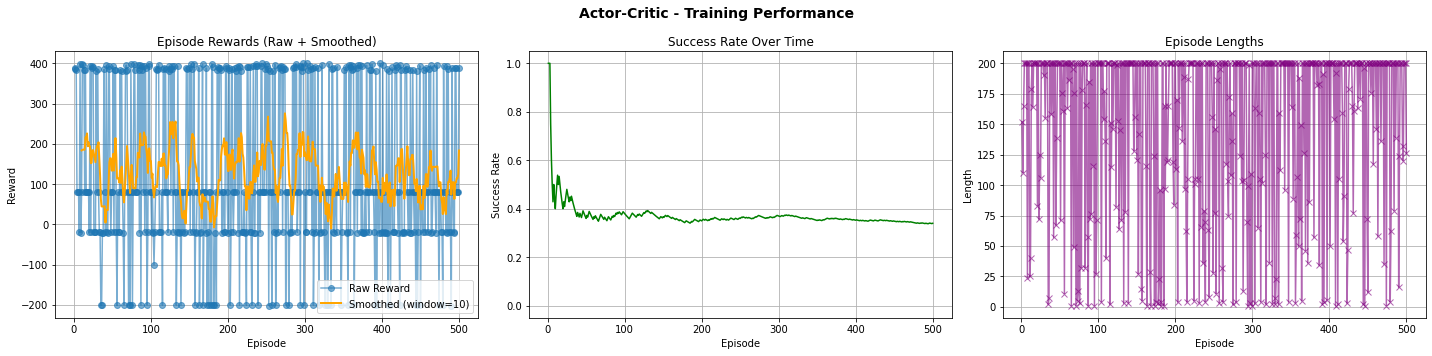


📈 Actor-Critic - Best Performance Metrics
Parameters: {'episodes': 500, 'alpha': 0.1, 'beta': 0.1, 'gamma': 0.9, 'epsilon': 0.2, 'MC_LR': 0.05, 'phase': 5}
  🟦 Best Raw Reward: 400.100  (Episode 397)
  🟧 Best Smoothed Reward: 275.850  (Episode 274)
  🟩 Best Success Rate: 1.000  (Episode 1)
  🟪 Longest Episode: 200 steps  (Episode 4)
  Average Episode Length: 147.95 steps


In [127]:
# ----------------- CELL 7: Results & Comparison (plots + optional summary) -----------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# === 1) Plot Learning Curves (Raw + Smoothed Rewards + Success Rate + Episode Lengths) ===
def plot_learning_curves(rewards, successes, episode_lengths, algo_name, smooth_window=10):
    episodes = np.arange(1, len(rewards) + 1)
    
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"{algo_name} - Training Performance", fontsize=14, fontweight='bold')

    # 1️⃣ Raw + Smoothed Reward Curve
    plt.subplot(1, 3, 1)
    plt.plot(episodes, rewards, marker='o', alpha=0.6, label='Raw Reward')
    if len(rewards) >= smooth_window:
        smooth_rewards = np.convolve(rewards, np.ones(smooth_window)/smooth_window, mode='valid')
        x = np.arange(smooth_window, len(rewards)+1)
        plt.plot(x, smooth_rewards, color='orange', linewidth=2, label=f'Smoothed (window={smooth_window})')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Episode Rewards (Raw + Smoothed)")
    plt.grid(True)
    plt.legend()

    # 2️⃣ Success Rate Curve
    plt.subplot(1, 3, 2)
    if len(successes) > 0:
        success_rate = np.cumsum(successes) / np.arange(1, len(successes)+1)
        plt.plot(np.arange(1, len(successes)+1), success_rate, color='green', label='Success Rate')
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.title("Success Rate Over Time")
    plt.ylim(-0.05, 1.05)
    plt.grid(True)

    # 3️⃣ Episode Length Curve
    plt.subplot(1, 3, 3)
    plt.plot(episodes, episode_lengths, color='purple', marker='x', alpha=0.6, label='Episode Length')
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title("Episode Lengths")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# === 2) Extract Best Metrics ===
def analyze_best_metrics(rewards, successes, episode_lengths, algo_name, smooth_window=10):
    # Raw rewards
    best_raw = np.max(rewards)
    best_raw_ep = np.argmax(rewards) + 1

    # Smoothed rewards
    if len(rewards) >= smooth_window:
        smooth_rewards = np.convolve(rewards, np.ones(smooth_window)/smooth_window, mode='valid')
        best_smooth = np.max(smooth_rewards)
        best_smooth_ep = np.argmax(smooth_rewards) + smooth_window
    else:
        best_smooth = np.max(rewards)
        best_smooth_ep = np.argmax(rewards) + 1

    # Success rate
    success_rate = np.cumsum(successes) / np.arange(1, len(successes)+1)
    best_success = np.max(success_rate)
    best_success_ep = np.argmax(success_rate) + 1

    # Episode length
    best_length = np.max(episode_lengths)
    best_length_ep = np.argmax(episode_lengths) + 1
    avg_length = np.mean(episode_lengths)

    print(f"\n📈 {algo_name} - Best Performance Metrics")
    print(f"Parameters: {params}")
    print(f"  🟦 Best Raw Reward: {best_raw:.3f}  (Episode {best_raw_ep})")
    print(f"  🟧 Best Smoothed Reward: {best_smooth:.3f}  (Episode {best_smooth_ep})")
    print(f"  🟩 Best Success Rate: {best_success:.3f}  (Episode {best_success_ep})")
    print(f"  🟪 Longest Episode: {best_length} steps  (Episode {best_length_ep})")
    print(f"  Average Episode Length: {avg_length:.2f} steps")


# === 3) Run plotting and metrics (use variables from CELL 6) ===
plot_learning_curves(rewards, successes, episode_lengths, algo_name)
analyze_best_metrics(rewards, successes, episode_lengths, algo_name)

# added here episode lengths and average length to the metrics summary

# FOR PERCENTAGE OF EVAL (TO BE EDITED PER PHASE)

In [40]:
import pandas as pd

# === 1. Define your max constants (adjust if needed) ===
MAX_REWARD = 30.400  # highest achievable reward observed
MAX_STEPS = 200     # your environment's timeout step

# === 2. Input your metrics per parameter setting ===
data = [
    {
        "Setting": "Default",
        "Best Raw Reward": 30.200,
        "Best Smoothed Reward": 25.560,
        "Best Success Rate": 1.000,   # already 0–1
        "Average Episode Length": 87.29
    },
    {
        "Setting": "High LR (α)",
        "Best Raw Reward": 30.400,
        "Best Smoothed Reward": 25.360,
        "Best Success Rate": 1.000,
        "Average Episode Length": 88.08
    },
    {
        "Setting": "Low LR (α)",
        "Best Raw Reward": 29.900,
        "Best Smoothed Reward": 24.710,
        "Best Success Rate": 1.000,
        "Average Episode Length": 94.80
    },
    {
        "Setting": "High ER (ε)",
        "Best Raw Reward": 30.100,
        "Best Smoothed Reward": 21.530,
        "Best Success Rate": 0.750,
        "Average Episode Length": 133.48
    },
    {
        "Setting": "Low ER (ε)",
        "Best Raw Reward": 29.800,
        "Best Smoothed Reward": 26.120,
        "Best Success Rate": 1.000,
        "Average Episode Length": 78.22
    },
    {
        "Setting": "High DF (γ)",
        "Best Raw Reward": 30.100,
        "Best Smoothed Reward": 25.020,
        "Best Success Rate": 1.000,
        "Average Episode Length": 101.45
    },
    {
        "Setting": "Low DF (γ)",
        "Best Raw Reward": 30.000,
        "Best Smoothed Reward": 23.810,
        "Best Success Rate": 1.000,
        "Average Episode Length": 96.93
    }
]

df = pd.DataFrame(data)

# === 3. Convert to percentage values ===
df["Best Raw Reward (%)"] = (df["Best Raw Reward"] / MAX_REWARD) * 100
df["Best Smoothed Reward (%)"] = (df["Best Smoothed Reward"] / MAX_REWARD) * 100
df["Best Success Rate (%)"] = df["Best Success Rate"] * 100
df["Average Episode Length (%)"] = (1 - (df["Average Episode Length"] / MAX_STEPS)) * 100  # efficiency

# === 4. Select and display percentage columns only ===
percent_df = df[["Setting",
                 "Best Raw Reward (%)",
                 "Best Smoothed Reward (%)",
                 "Best Success Rate (%)",
                 "Average Episode Length (%)"]]

print("\n=== Converted Performance to Percentage Form ===")
print(percent_df.round(2))

# for evaluation only; not part of main flow



=== Converted Performance to Percentage Form ===
       Setting  Best Raw Reward (%)  Best Smoothed Reward (%)  \
0      Default                99.34                     84.08   
1  High LR (α)               100.00                     83.42   
2   Low LR (α)                98.36                     81.28   
3  High ER (ε)                99.01                     70.82   
4   Low ER (ε)                98.03                     85.92   
5  High DF (γ)                99.01                     82.30   
6   Low DF (γ)                98.68                     78.32   

   Best Success Rate (%)  Average Episode Length (%)  
0                  100.0                       56.36  
1                  100.0                       55.96  
2                  100.0                       52.60  
3                   75.0                       33.26  
4                  100.0                       60.89  
5                  100.0                       49.28  
6                  100.0                    